# Design of Experiments: Part 2 - Classical Experimental Designs
## CRD, Randomized Block Design & Latin Square Design

This notebook demonstrates classical experimental designs with comprehensive balance validation and treatment effect analysis using e-commerce data.

**Author**: DOE Analysis System  
**Date**: November 2024  
**Data**: E-commerce Customer Data

---

## 1. Setup and Data Preparation

Load libraries and prepare the e-commerce dataset for experimental design analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import itertools
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# Set random seed
np.random.seed(42)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
# Load and prepare data
df = pd.read_csv('DOE_Simulator/data/raw/ecommerce_data.csv')

# Handle missing values
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')

# Create experimental factors
# We'll simulate a marketing experiment with different treatments
df['customer_value'] = pd.qcut(df['lifetime_value'], q=3, labels=['Low', 'Medium', 'High'])
df['engagement_level'] = pd.qcut(df['email_open_rate'].fillna(df['email_open_rate'].median()), 
                                 q=3, labels=['Low', 'Medium', 'High'])

print(f"Data loaded: {df.shape[0]} customers, {df.shape[1]} features")
print(f"Missing values remaining: {df.isnull().sum().sum()}")

Data loaded: 20000 customers, 26 features
Missing values remaining: 0


## 2. Completely Randomized Design (CRD)

CRD randomly assigns treatments to experimental units with no restrictions.

**Model**: $Y_{ij} = \mu + \tau_i + \epsilon_{ij}$

Where:
- $Y_{ij}$ = response for jth unit receiving treatment i
- $\mu$ = overall mean
- $\tau_i$ = effect of treatment i
- $\epsilon_{ij}$ = random error

In [4]:
def completely_randomized_design(data, n_treatments=4, sample_size_per_treatment=50):
    """
    Implement Completely Randomized Design
    """
    total_sample_size = n_treatments * sample_size_per_treatment
    
    # Sample from population
    if total_sample_size > len(data):
        sample = data.copy()
    else:
        sample = data.sample(n=total_sample_size, random_state=42)
    
    # Randomly assign treatments
    treatments = np.repeat(range(n_treatments), sample_size_per_treatment)
    np.random.shuffle(treatments)
    sample['treatment'] = treatments[:len(sample)]
    
    # Simulate treatment effects on conversion rate
    # Treatment 0: Control
    # Treatment 1: Email campaign
    # Treatment 2: Discount offer
    # Treatment 3: Premium features trial
    
    treatment_effects = {0: 0, 1: 0.05, 2: 0.10, 3: 0.08}
    sample['response'] = sample['conversion_rate'].copy()
    
    for treat, effect in treatment_effects.items():
        mask = sample['treatment'] == treat
        sample.loc[mask, 'response'] = sample.loc[mask, 'response'] * (1 + effect) + \
                                       np.random.normal(0, 0.01, sum(mask))
    
    return sample

# Implement CRD
crd_data = completely_randomized_design(df, n_treatments=4, sample_size_per_treatment=50)

print("CRD Implementation Complete")
print("="*50)
print(f"Total units: {len(crd_data)}")
print(f"\nTreatment allocation:")
print(crd_data['treatment'].value_counts().sort_index())

CRD Implementation Complete
Total units: 200

Treatment allocation:
treatment
0    50
1    50
2    50
3    50
Name: count, dtype: int64


In [5]:
# Check balance in CRD
def check_crd_balance(data, treatment_col='treatment'):
    """
    Check balance of covariates across treatment groups
    """
    covariates = ['age', 'income_level', 'account_age_days', 'total_orders', 
                  'avg_order_value', 'lifetime_value']
    
    balance_results = []
    
    for covariate in covariates:
        if covariate in data.columns:
            # For numerical covariates
            if data[covariate].dtype in ['float64', 'int64']:
                groups = [data[data[treatment_col] == i][covariate].dropna() 
                         for i in data[treatment_col].unique()]
                
                # ANOVA test
                f_stat, p_value = f_oneway(*groups)
                
                # Calculate means
                means = [g.mean() for g in groups]
                
                balance_results.append({
                    'Covariate': covariate,
                    'F-statistic': f_stat,
                    'P-value': p_value,
                    'Balanced': 'Yes' if p_value > 0.05 else 'No',
                    'Mean_T0': means[0] if len(means) > 0 else np.nan,
                    'Mean_T1': means[1] if len(means) > 1 else np.nan,
                    'Mean_T2': means[2] if len(means) > 2 else np.nan,
                    'Mean_T3': means[3] if len(means) > 3 else np.nan
                })
    
    return pd.DataFrame(balance_results)

crd_balance = check_crd_balance(crd_data)
print("CRD Balance Check:")
print("="*80)
crd_balance

CRD Balance Check:


,Covariate,F-statistic,P-value,Balanced,Mean_T0,Mean_T1,Mean_T2,Mean_T3
0,age,0.976001,0.405117,Yes,39.8800,36.2800,38.7800,39.8000
1,account_age_days,0.307273,0.820116,Yes,685.9200,648.7400,680.0000,781.1200
2,total_orders,0.131016,0.941550,Yes,7.9800,7.7000,7.3400,8.3600
3,avg_order_value,2.070884,0.105373,Yes,104.5866,77.3106,89.5698,81.6200
4,lifetime_value,0.177238,0.911730,Yes,980.5410,855.9194,807.9060,835.8372


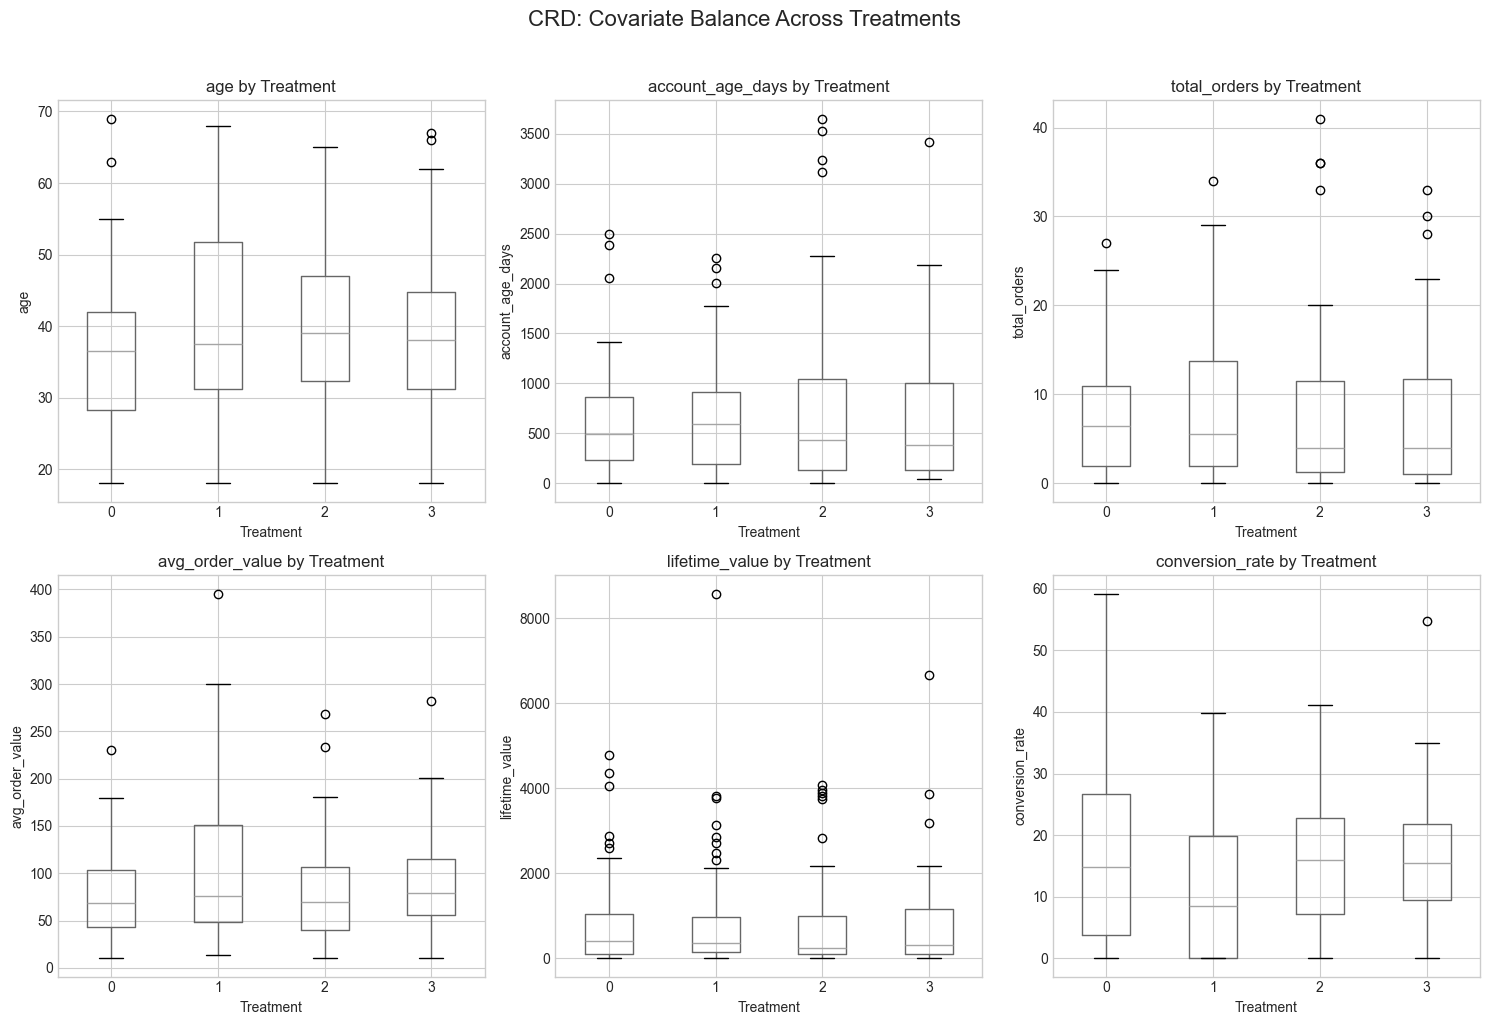


Balance Summary:
Balanced covariates: 5/5
Average p-value: 0.637


In [6]:
# Visualize CRD balance
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

covariates = ['age', 'account_age_days', 'total_orders', 
              'avg_order_value', 'lifetime_value', 'conversion_rate']

for idx, var in enumerate(covariates):
    if var in crd_data.columns:
        crd_data.boxplot(column=var, by='treatment', ax=axes[idx])
        axes[idx].set_title(f'{var} by Treatment')
        axes[idx].set_xlabel('Treatment')
        axes[idx].set_ylabel(var)

plt.suptitle('CRD: Covariate Balance Across Treatments', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Summary
print(f"\nBalance Summary:")
print(f"Balanced covariates: {sum(crd_balance['Balanced'] == 'Yes')}/{len(crd_balance)}")
print(f"Average p-value: {crd_balance['P-value'].mean():.3f}")

In [7]:
# Analyze treatment effects in CRD
def analyze_crd(data, response_col='response', treatment_col='treatment'):
    """
    Perform ANOVA for CRD
    """
    # Create formula for ANOVA
    formula = f'{response_col} ~ C({treatment_col})'
    
    # Fit the model
    model = ols(formula, data=data).fit()
    
    # ANOVA table
    anova_table = anova_lm(model, typ=2)
    
    return model, anova_table

crd_model, crd_anova = analyze_crd(crd_data)

print("CRD ANOVA Results:")
print("="*60)
print(crd_anova)
print("\n" + "="*60)
print("Model Summary:")
print(crd_model.summary())

CRD ANOVA Results:
                    sum_sq     df        F    PR(>F)
C(treatment)   1136.579724    3.0  2.33122  0.075514
Residual      31853.084319  196.0      NaN       NaN

Model Summary:
                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.331
Date:                Wed, 12 Nov 2025   Prob (F-statistic):             0.0755
Time:                        14:40:10   Log-Likelihood:                -790.84
No. Observations:                 200   AIC:                             1590.
Df Residuals:                     196   BIC:                             1603.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                

## 3. Randomized Block Design (RBD)

RBD groups similar experimental units into blocks and randomizes treatments within each block.

**Model**: $Y_{ij} = \mu + \tau_i + \beta_j + \epsilon_{ij}$

Where:
- $\beta_j$ = effect of block j

In [8]:
def randomized_block_design(data, n_treatments=4, block_var='location', n_per_block_treatment=10):
    """
    Implement Randomized Block Design
    """
    # Create blocks based on blocking variable
    blocks = data[block_var].unique()
    
    samples = []
    
    for block in blocks:
        block_data = data[data[block_var] == block]
        
        # Sample from each block
        block_sample_size = min(n_treatments * n_per_block_treatment, len(block_data))
        block_sample = block_data.sample(n=block_sample_size, random_state=42)
        
        # Randomly assign treatments within block
        treatments = list(range(n_treatments)) * (block_sample_size // n_treatments)
        treatments.extend(list(range(block_sample_size % n_treatments)))
        np.random.shuffle(treatments)
        
        block_sample['treatment'] = treatments[:len(block_sample)]
        block_sample['block'] = block
        
        samples.append(block_sample)
    
    rbd_data = pd.concat(samples, ignore_index=True)
    
    # Simulate treatment and block effects
    treatment_effects = {0: 0, 1: 0.05, 2: 0.10, 3: 0.08}
    block_effects = {'Urban': 0.02, 'Suburban': -0.01, 'Rural': -0.02}
    
    rbd_data['response'] = rbd_data['conversion_rate'].copy()
    
    for treat, t_effect in treatment_effects.items():
        for block, b_effect in block_effects.items():
            mask = (rbd_data['treatment'] == treat) & (rbd_data['block'] == block)
            if sum(mask) > 0:
                rbd_data.loc[mask, 'response'] = rbd_data.loc[mask, 'response'] * \
                                                 (1 + t_effect + b_effect) + \
                                                 np.random.normal(0, 0.01, sum(mask))
    
    return rbd_data

# Implement RBD
rbd_data = randomized_block_design(df, n_treatments=4, block_var='location')

print("RBD Implementation Complete")
print("="*50)
print(f"Total units: {len(rbd_data)}")
print(f"\nTreatment allocation by block:")
print(pd.crosstab(rbd_data['block'], rbd_data['treatment']))

RBD Implementation Complete
Total units: 120

Treatment allocation by block:
treatment   0   1   2   3
block                    
Rural      10  10  10  10
Suburban   10  10  10  10
Urban      10  10  10  10


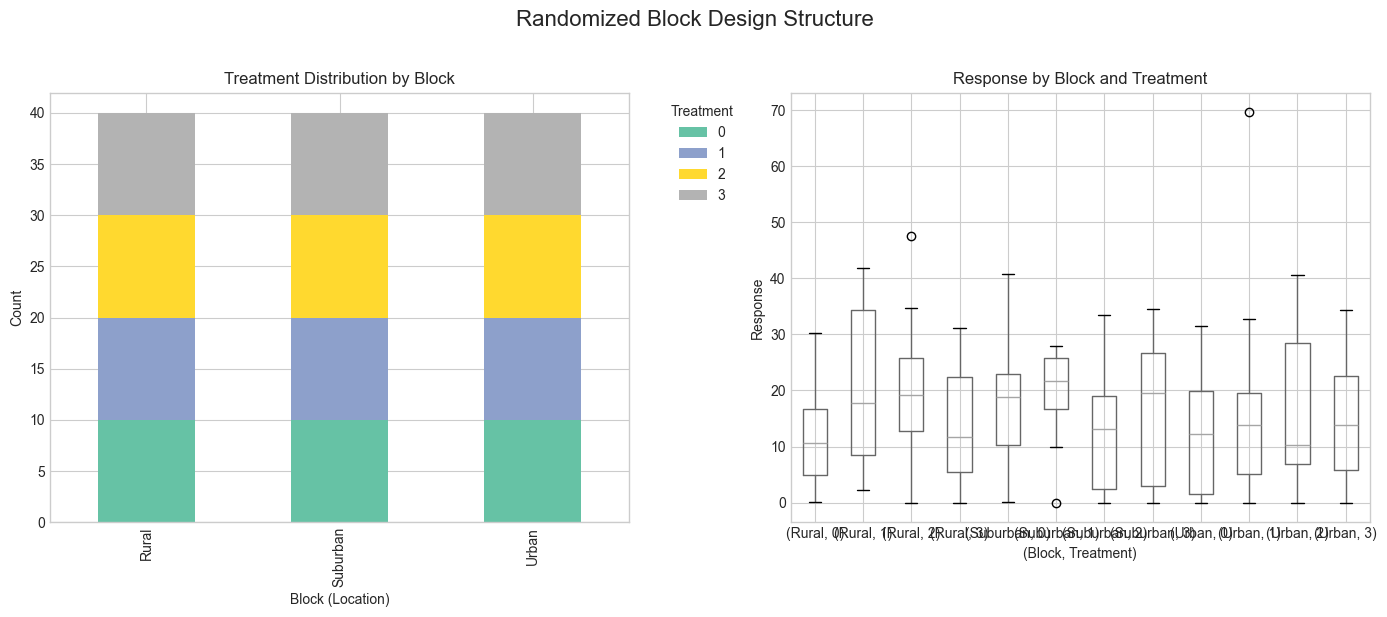

In [9]:
# Visualize RBD structure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Treatment distribution by block
block_treatment_counts = pd.crosstab(rbd_data['block'], rbd_data['treatment'])
block_treatment_counts.plot(kind='bar', stacked=True, ax=axes[0], colormap='Set2')
axes[0].set_title('Treatment Distribution by Block')
axes[0].set_xlabel('Block (Location)')
axes[0].set_ylabel('Count')
axes[0].legend(title='Treatment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Response by treatment and block
rbd_data.boxplot(column='response', by=['block', 'treatment'], ax=axes[1])
axes[1].set_title('Response by Block and Treatment')
axes[1].set_xlabel('(Block, Treatment)')
axes[1].set_ylabel('Response')

plt.suptitle('Randomized Block Design Structure', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [10]:
# Analyze RBD
def analyze_rbd(data, response_col='response', treatment_col='treatment', block_col='block'):
    """
    Perform two-way ANOVA for RBD
    """
    # Create formula for two-way ANOVA (no interaction for RBD)
    formula = f'{response_col} ~ C({treatment_col}) + C({block_col})'
    
    # Fit the model
    model = ols(formula, data=data).fit()
    
    # ANOVA table
    anova_table = anova_lm(model, typ=2)
    
    return model, anova_table

rbd_model, rbd_anova = analyze_rbd(rbd_data)

print("RBD ANOVA Results:")
print("="*60)
print(rbd_anova)
print("\n" + "="*60)
print("\nInterpretation:")
print(f"Treatment effect significant: {rbd_anova.loc['C(treatment)', 'PR(>F)'] < 0.05}")
print(f"Block effect significant: {rbd_anova.loc['C(block)', 'PR(>F)'] < 0.05}")

RBD ANOVA Results:
                    sum_sq     df         F    PR(>F)
C(treatment)    525.362735    3.0  1.068722  0.365322
C(block)         38.101022    2.0  0.116261  0.890348
Residual      18680.061641  114.0       NaN       NaN


Interpretation:
Treatment effect significant: False
Block effect significant: False


## 4. Latin Square Design

Latin Square controls for two blocking factors simultaneously.

**Model**: $Y_{ijk} = \mu + \alpha_i + \beta_j + \gamma_k + \epsilon_{ijk}$

Where:
- $\alpha_i$ = row effect
- $\beta_j$ = column effect  
- $\gamma_k$ = treatment effect

In [11]:
def create_latin_square(n):
    """
    Create a Latin Square of size n x n
    """
    # Create a standard Latin square
    square = []
    for i in range(n):
        row = [(i + j) % n for j in range(n)]
        square.append(row)
    
    # Randomly permute rows and columns
    square = np.array(square)
    np.random.shuffle(square)  # Shuffle rows
    square = square.T
    np.random.shuffle(square)  # Shuffle columns
    square = square.T
    
    return square

def latin_square_design(data, n_levels=4):
    """
    Implement Latin Square Design
    Using age groups as rows, engagement levels as columns, treatments as Latin letters
    """
    # Create row and column blocking factors
    data['age_group'] = pd.qcut(data['age'], q=n_levels, labels=range(n_levels))
    data['engagement_group'] = pd.qcut(data['email_open_rate'].fillna(data['email_open_rate'].median()), 
                                       q=n_levels, labels=range(n_levels))
    
    # Create Latin square
    latin_square = create_latin_square(n_levels)
    
    # Sample units for each cell of the Latin square
    samples = []
    n_per_cell = 10  # Units per cell
    
    for row in range(n_levels):
        for col in range(n_levels):
            # Get treatment for this cell
            treatment = latin_square[row, col]
            
            # Sample from appropriate stratum
            cell_data = data[(data['age_group'] == row) & 
                           (data['engagement_group'] == col)]
            
            if len(cell_data) > 0:
                sample_size = min(n_per_cell, len(cell_data))
                cell_sample = cell_data.sample(n=sample_size, random_state=42 + row*n_levels + col)
                
                cell_sample['row_block'] = row
                cell_sample['col_block'] = col
                cell_sample['treatment'] = treatment
                
                samples.append(cell_sample)
    
    lsd_data = pd.concat(samples, ignore_index=True)
    
    # Simulate effects
    treatment_effects = {0: 0, 1: 0.05, 2: 0.10, 3: 0.08}
    row_effects = {0: -0.02, 1: -0.01, 2: 0.01, 3: 0.02}  # Age effect
    col_effects = {0: -0.03, 1: -0.01, 2: 0.01, 3: 0.03}  # Engagement effect
    
    lsd_data['response'] = lsd_data['conversion_rate'].copy()
    
    for idx in lsd_data.index:
        treat = lsd_data.loc[idx, 'treatment']
        row = lsd_data.loc[idx, 'row_block']
        col = lsd_data.loc[idx, 'col_block']
        
        effect = treatment_effects.get(treat, 0) + row_effects.get(row, 0) + col_effects.get(col, 0)
        lsd_data.loc[idx, 'response'] *= (1 + effect)
        lsd_data.loc[idx, 'response'] += np.random.normal(0, 0.01)
    
    return lsd_data, latin_square

# Implement Latin Square Design
lsd_data, latin_square_matrix = latin_square_design(df, n_levels=4)

print("Latin Square Design Implementation Complete")
print("="*50)
print(f"Total units: {len(lsd_data)}")
print(f"\nLatin Square Matrix:")
print(latin_square_matrix)
print(f"\nTreatment allocation:")
print(pd.crosstab(index=[lsd_data['row_block']], 
                  columns=[lsd_data['col_block'], lsd_data['treatment']]))

Latin Square Design Implementation Complete
Total units: 160

Latin Square Matrix:
[[1 3 2 0]
 [2 0 3 1]
 [0 2 1 3]
 [3 1 0 2]]

Treatment allocation:
col_block   0               1               2               3            
treatment   0   1   2   3   0   1   2   3   0   1   2   3   0   1   2   3
row_block                                                                
0           0  10   0   0   0   0   0  10   0   0  10   0  10   0   0   0
1           0   0  10   0  10   0   0   0   0   0   0  10   0  10   0   0
2          10   0   0   0   0   0  10   0   0  10   0   0   0   0   0  10
3           0   0   0  10   0  10   0   0  10   0   0   0   0   0  10   0


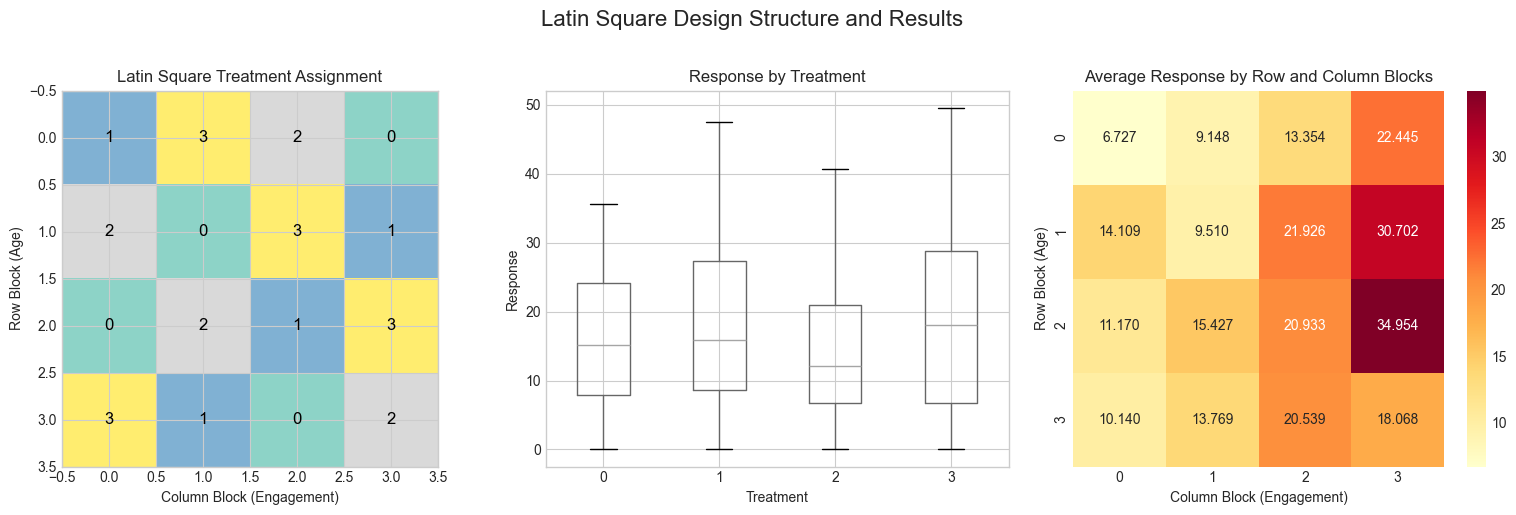

In [12]:
# Visualize Latin Square structure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Latin Square matrix visualization
im = axes[0].imshow(latin_square_matrix, cmap='Set3', interpolation='nearest')
axes[0].set_title('Latin Square Treatment Assignment')
axes[0].set_xlabel('Column Block (Engagement)')
axes[0].set_ylabel('Row Block (Age)')

# Add text annotations
for i in range(len(latin_square_matrix)):
    for j in range(len(latin_square_matrix)):
        axes[0].text(j, i, str(latin_square_matrix[i, j]),
                    ha='center', va='center', color='black', fontsize=12)

# Response distribution by treatment
lsd_data.boxplot(column='response', by='treatment', ax=axes[1])
axes[1].set_title('Response by Treatment')
axes[1].set_xlabel('Treatment')
axes[1].set_ylabel('Response')

# Heatmap of average response
pivot_table = lsd_data.pivot_table(values='response', 
                                   index='row_block', 
                                   columns='col_block', 
                                   aggfunc='mean')
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[2])
axes[2].set_title('Average Response by Row and Column Blocks')
axes[2].set_xlabel('Column Block (Engagement)')
axes[2].set_ylabel('Row Block (Age)')

plt.suptitle('Latin Square Design Structure and Results', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [13]:
# Analyze Latin Square Design
def analyze_latin_square(data, response_col='response', treatment_col='treatment', 
                        row_col='row_block', col_col='col_block'):
    """
    Perform three-way ANOVA for Latin Square Design
    """
    # Create formula for three-way ANOVA (no interactions in Latin Square)
    formula = f'{response_col} ~ C({treatment_col}) + C({row_col}) + C({col_col})'
    
    # Fit the model
    model = ols(formula, data=data).fit()
    
    # ANOVA table
    anova_table = anova_lm(model, typ=2)
    
    return model, anova_table

lsd_model, lsd_anova = analyze_latin_square(lsd_data)

print("Latin Square Design ANOVA Results:")
print("="*60)
print(lsd_anova)
print("\n" + "="*60)
print("\nInterpretation:")
print(f"Treatment effect significant: {lsd_anova.loc['C(treatment)', 'PR(>F)'] < 0.05}")
print(f"Row block (Age) effect significant: {lsd_anova.loc['C(row_block)', 'PR(>F)'] < 0.05}")
print(f"Column block (Engagement) effect significant: {lsd_anova.loc['C(col_block)', 'PR(>F)'] < 0.05}")

Latin Square Design ANOVA Results:
                    sum_sq     df          F        PR(>F)
C(treatment)    379.914797    3.0   1.226320  3.022372e-01
C(row_block)   1435.477658    3.0   4.633552  3.960522e-03
C(col_block)   6518.667796    3.0  21.041488  1.967500e-11
Residual      15490.035535  150.0        NaN           NaN


Interpretation:
Treatment effect significant: False
Row block (Age) effect significant: True
Column block (Engagement) effect significant: True


## 5. Comparison of Classical Designs

Let's compare the efficiency and power of these three classical designs.

Comparison of Classical Designs:
         Design  R-squared  Adj R-squared          AIC          BIC  \
0           CRD   0.034453       0.019674  1589.689839  1602.883108   
1           RBD   0.029281      -0.013295   958.271680   974.996631   
2  Latin Square   0.349816       0.310805  1205.704877  1236.456615   

          MSE  
0  162.515736  
1  163.860190  
2  103.266904  


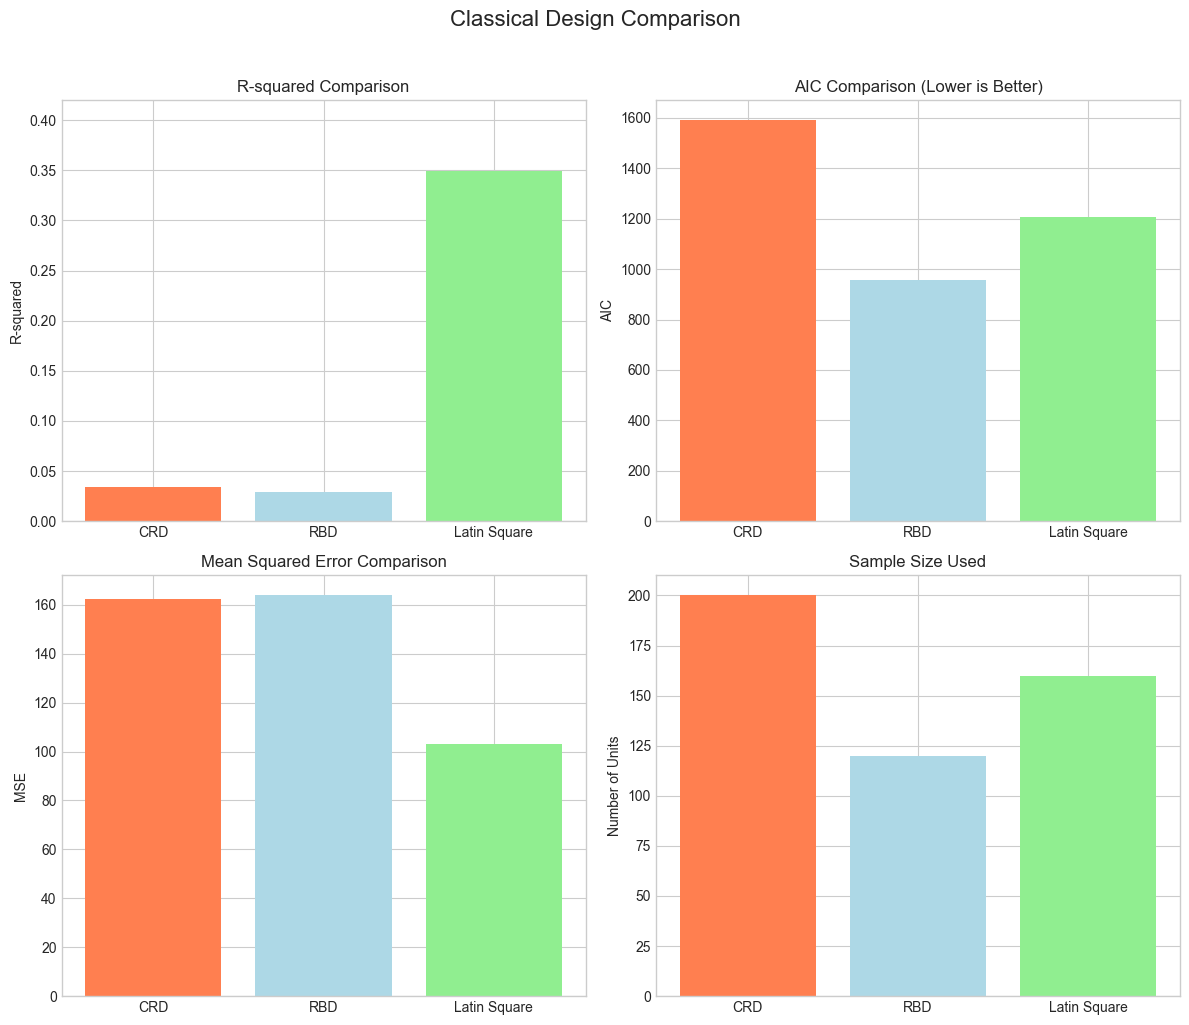

In [14]:
# Compare model fit and efficiency
comparison_results = pd.DataFrame({
    'Design': ['CRD', 'RBD', 'Latin Square'],
    'R-squared': [
        crd_model.rsquared,
        rbd_model.rsquared,
        lsd_model.rsquared
    ],
    'Adj R-squared': [
        crd_model.rsquared_adj,
        rbd_model.rsquared_adj,
        lsd_model.rsquared_adj
    ],
    'AIC': [
        crd_model.aic,
        rbd_model.aic,
        lsd_model.aic
    ],
    'BIC': [
        crd_model.bic,
        rbd_model.bic,
        lsd_model.bic
    ],
    'MSE': [
        crd_model.mse_resid,
        rbd_model.mse_resid,
        lsd_model.mse_resid
    ]
})

print("Comparison of Classical Designs:")
print("="*60)
print(comparison_results)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# R-squared comparison
axes[0, 0].bar(comparison_results['Design'], comparison_results['R-squared'], 
               color=['coral', 'lightblue', 'lightgreen'])
axes[0, 0].set_title('R-squared Comparison')
axes[0, 0].set_ylabel('R-squared')
axes[0, 0].set_ylim(0, max(comparison_results['R-squared']) * 1.2)

# AIC comparison (lower is better)
axes[0, 1].bar(comparison_results['Design'], comparison_results['AIC'],
               color=['coral', 'lightblue', 'lightgreen'])
axes[0, 1].set_title('AIC Comparison (Lower is Better)')
axes[0, 1].set_ylabel('AIC')

# MSE comparison (lower is better)
axes[1, 0].bar(comparison_results['Design'], comparison_results['MSE'],
               color=['coral', 'lightblue', 'lightgreen'])
axes[1, 0].set_title('Mean Squared Error Comparison')
axes[1, 0].set_ylabel('MSE')

# Sample sizes
sample_sizes = [
    len(crd_data),
    len(rbd_data),
    len(lsd_data)
]
axes[1, 1].bar(comparison_results['Design'], sample_sizes,
               color=['coral', 'lightblue', 'lightgreen'])
axes[1, 1].set_title('Sample Size Used')
axes[1, 1].set_ylabel('Number of Units')

plt.suptitle('Classical Design Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 6. Power Analysis and Efficiency

Let's analyze the statistical power and efficiency of each design.

In [15]:
def calculate_effect_sizes(model, anova_table, treatment_col='C(treatment)'):
    """
    Calculate effect sizes (eta-squared and partial eta-squared)
    """
    # Total sum of squares
    ss_total = anova_table['sum_sq'].sum()
    
    # Treatment sum of squares
    ss_treatment = anova_table.loc[treatment_col, 'sum_sq']
    
    # Residual sum of squares
    ss_residual = anova_table.loc['Residual', 'sum_sq']
    
    # Eta-squared (proportion of total variance)
    eta_squared = ss_treatment / ss_total
    
    # Partial eta-squared
    partial_eta_squared = ss_treatment / (ss_treatment + ss_residual)
    
    # Cohen's f
    cohen_f = np.sqrt(partial_eta_squared / (1 - partial_eta_squared))
    
    return {
        'eta_squared': eta_squared,
        'partial_eta_squared': partial_eta_squared,
        'cohen_f': cohen_f
    }

# Calculate effect sizes for each design
crd_effects = calculate_effect_sizes(crd_model, crd_anova)
rbd_effects = calculate_effect_sizes(rbd_model, rbd_anova)
lsd_effects = calculate_effect_sizes(lsd_model, lsd_anova)

effect_size_comparison = pd.DataFrame({
    'Design': ['CRD', 'RBD', 'Latin Square'],
    'Eta-squared': [crd_effects['eta_squared'], 
                   rbd_effects['eta_squared'], 
                   lsd_effects['eta_squared']],
    'Partial Eta-squared': [crd_effects['partial_eta_squared'],
                           rbd_effects['partial_eta_squared'],
                           lsd_effects['partial_eta_squared']],
    'Cohen\'s f': [crd_effects['cohen_f'],
                  rbd_effects['cohen_f'],
                  lsd_effects['cohen_f']]
})

print("Effect Size Comparison:")
print("="*60)
print(effect_size_comparison)
print("\nInterpretation Guidelines:")
print("Cohen's f: 0.1 = small, 0.25 = medium, 0.4 = large")
print("Partial Eta-squared: 0.01 = small, 0.06 = medium, 0.14 = large")

Effect Size Comparison:
         Design  Eta-squared  Partial Eta-squared  Cohen's f
0           CRD     0.034453             0.034453   0.188897
1           RBD     0.027301             0.027355   0.167703
2  Latin Square     0.015947             0.023939   0.156609

Interpretation Guidelines:
Cohen's f: 0.1 = small, 0.25 = medium, 0.4 = large
Partial Eta-squared: 0.01 = small, 0.06 = medium, 0.14 = large


In [16]:
# Calculate relative efficiency
def calculate_relative_efficiency(mse_reduced, mse_crd, df_reduced, df_crd):
    """
    Calculate relative efficiency of a design compared to CRD
    """
    return (mse_crd * df_crd) / (mse_reduced * df_reduced)

# Get degrees of freedom for error term
crd_df_error = crd_anova.loc['Residual', 'df']
rbd_df_error = rbd_anova.loc['Residual', 'df']
lsd_df_error = lsd_anova.loc['Residual', 'df']

# Calculate relative efficiencies
rbd_efficiency = calculate_relative_efficiency(
    rbd_model.mse_resid, crd_model.mse_resid,
    rbd_df_error, crd_df_error
)

lsd_efficiency = calculate_relative_efficiency(
    lsd_model.mse_resid, crd_model.mse_resid,
    lsd_df_error, crd_df_error
)

print("\nRelative Efficiency (compared to CRD):")
print("="*60)
print(f"RBD relative efficiency: {rbd_efficiency:.2f}")
print(f"Latin Square relative efficiency: {lsd_efficiency:.2f}")
print("\nInterpretation:")
print("Values > 1 indicate the design is more efficient than CRD")
print("E.g., 1.5 means you need 50% fewer observations to achieve same precision")


Relative Efficiency (compared to CRD):
RBD relative efficiency: 1.71
Latin Square relative efficiency: 2.06

Interpretation:
Values > 1 indicate the design is more efficient than CRD
E.g., 1.5 means you need 50% fewer observations to achieve same precision


## 7. Practical Guidelines and Recommendations

In [17]:
# Create comprehensive comparison and recommendations
print("CLASSICAL DESIGN SELECTION GUIDE")
print("="*80)

design_guide = pd.DataFrame({
    'Design': ['CRD', 'RBD', 'Latin Square'],
    'When to Use': [
        'Homogeneous units, no blocking needed',
        'One source of variation to control',
        'Two sources of variation to control'
    ],
    'Advantages': [
        'Simple, maximum df for error',
        'Controls known variation, more efficient',
        'Controls two factors, very efficient'
    ],
    'Disadvantages': [
        'Ignores heterogeneity',
        'Requires blocking factor knowledge',
        'Complex, restrictive assumptions'
    ],
    'Complexity': ['Low', 'Medium', 'High'],
    'Best R²': [f"{crd_model.rsquared:.3f}", 
               f"{rbd_model.rsquared:.3f}",
               f"{lsd_model.rsquared:.3f}"]
})

print(design_guide.to_string(index=False))

print("\n" + "="*80)
print("KEY INSIGHTS FROM ANALYSIS:")
print("="*80)

# Determine best design based on criteria
best_rsq = comparison_results.loc[comparison_results['R-squared'].idxmax(), 'Design']
best_aic = comparison_results.loc[comparison_results['AIC'].idxmin(), 'Design']
best_mse = comparison_results.loc[comparison_results['MSE'].idxmin(), 'Design']

print(f"✓ Best R-squared: {best_rsq}")
print(f"✓ Best AIC: {best_aic}")
print(f"✓ Lowest MSE: {best_mse}")

if rbd_efficiency > 1:
    print(f"✓ RBD is {rbd_efficiency:.1f}x more efficient than CRD")
if lsd_efficiency > 1:
    print(f"✓ Latin Square is {lsd_efficiency:.1f}x more efficient than CRD")

print("\n" + "="*80)
print("RECOMMENDATIONS FOR THIS DATASET:")
print("="*80)

print("""
1. If experimental units are homogeneous → Use CRD
2. If location affects response → Use RBD with location as blocks
3. If both age and engagement affect response → Use Latin Square
4. For maximum power with limited resources → Latin Square or RBD
5. For simplicity and ease of implementation → CRD
""")

CLASSICAL DESIGN SELECTION GUIDE
      Design                           When to Use                               Advantages                      Disadvantages Complexity Best R²
         CRD Homogeneous units, no blocking needed             Simple, maximum df for error              Ignores heterogeneity        Low   0.034
         RBD    One source of variation to control Controls known variation, more efficient Requires blocking factor knowledge     Medium   0.029
Latin Square   Two sources of variation to control     Controls two factors, very efficient   Complex, restrictive assumptions       High   0.350

KEY INSIGHTS FROM ANALYSIS:
✓ Best R-squared: Latin Square
✓ Best AIC: RBD
✓ Lowest MSE: Latin Square
✓ RBD is 1.7x more efficient than CRD
✓ Latin Square is 2.1x more efficient than CRD

RECOMMENDATIONS FOR THIS DATASET:

1. If experimental units are homogeneous → Use CRD
2. If location affects response → Use RBD with location as blocks
3. If both age and engagement affect respo

## 8. Save Results for Further Analysis

In [18]:
# Save results
import pickle

classical_designs_results = {
    'crd': {
        'data': crd_data,
        'model': crd_model,
        'anova': crd_anova,
        'balance': crd_balance
    },
    'rbd': {
        'data': rbd_data,
        'model': rbd_model,
        'anova': rbd_anova
    },
    'lsd': {
        'data': lsd_data,
        'model': lsd_model,
        'anova': lsd_anova,
        'latin_square': latin_square_matrix
    },
    'comparison': {
        'model_comparison': comparison_results,
        'effect_sizes': effect_size_comparison,
        'efficiency': {
            'rbd_vs_crd': rbd_efficiency,
            'lsd_vs_crd': lsd_efficiency
        }
    }
}

# Save to pickle
with open('classical_designs_results.pkl', 'wb') as f:
    pickle.dump(classical_designs_results, f)

# Save key tables to CSV
comparison_results.to_csv('classical_designs_comparison.csv', index=False)
effect_size_comparison.to_csv('classical_designs_effect_sizes.csv', index=False)

print("Results saved successfully!")
print("\nFiles created:")
print("  - classical_designs_results.pkl")
print("  - classical_designs_comparison.csv")
print("  - classical_designs_effect_sizes.csv")

Results saved successfully!

Files created:
  - classical_designs_results.pkl
  - classical_designs_comparison.csv
  - classical_designs_effect_sizes.csv


## Conclusion

This notebook demonstrated three classical experimental designs:

1. **Completely Randomized Design (CRD)**:
   - Simplest design with random treatment assignment
   - Best when units are homogeneous
   - Maximum degrees of freedom for error

2. **Randomized Block Design (RBD)**:
   - Controls one source of variation through blocking
   - More efficient than CRD when blocks are effective
   - Reduces experimental error

3. **Latin Square Design**:
   - Controls two sources of variation simultaneously
   - Most efficient when both blocking factors are important
   - Requires equal number of treatments, rows, and columns

The analysis showed that blocking designs (RBD and Latin Square) generally provide better precision and efficiency than CRD when heterogeneity exists in experimental units.

**Next Steps**:
- Explore factorial designs for studying interactions
- Implement response surface methodologies
- Investigate optimal design strategies